# Verify that Numba fitting produced correct results.

Since using `fastmath=True` did not change the run time of the `numba`-optimised code, we will only analyse the non-fastmath-verified system.

The TI9 dataset encompasses the final 193 maps of the Aug 31, 2019 dataset.

## Setup

In [1]:
import os
if 'src' not in os.listdir():
    os.chdir("..")

In [146]:
import gzip
import json
import pickle
from importlib import reload

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from src import load
import src.models.gp
import src.stats
import src.statics

In [3]:
pd.set_option('max_rows', 6)
pd.set_option('max_columns', 50)

sns.set()

## Load data

In [125]:
reload(src.load)

<module 'src.load' from '/Users/yl3/github/dota2/src/load.py'>

In [126]:
with gzip.open('data/raw/premium_matches.2019-08-31.json.gz', 'rb') as fh:
    premium_matches = load.matches_json_to_df(json.load(fh)['data'])
    matches = load.MatchDF(premium_matches)

### Regular fit

In [127]:
pred_df = pd.read_csv('fitted/ti9_full_new_params_by_map.win_probs.gz',
                      header=0, sep='\t', index_col=0)
skills_mat = pd.read_csv('fitted/ti9_full_new_params_by_map.player_skills.gz',
                         header=0, sep='\t', index_col=0)
skills_mat.columns = skills_mat.columns.astype(int)

match_pred = src.stats.MatchPred(matches, pred_df, 3.0, skills_mat)

### Fit with Numba

In [169]:
pred_df_numba = pd.read_csv(
    'fitted/ti9_full_new_params_by_map_numba.win_probs.gz',
    header=0,
    sep='\t',
    index_col=0)
skills_mat_numba = pd.read_csv(
    'fitted/ti9_full_new_params_by_map_numba.player_skills.gz',
    header=0,
    sep='\t',
    index_col=0)
skills_mat_numba = skills_mat_numba.reindex(skills_mat.index)
skills_mat_numba.columns = skills_mat_numba.columns.astype(int)

match_pred_numba = src.stats.MatchPred(matches, pred_df_numba, 3.0,
                                       skills_mat_numba)

### Fairlay odds

In [164]:
fl = pd.read_pickle("data/external/dota2_markets.20190831.pkl")
sel = ((fl.Comp == 'Dota 2 - The International')
       & (fl.dota_market_type == 'map'))
fl_f = (fl.loc[sel].sort_values('LastCh')
        .groupby(['ID', 'wager_type', 'RunnerName'])
        .apply(lambda d: d.iloc[0]))
fl_f_teams = fl_f.Title.str.extract(r'^(.+) vs. (.+)$')
fl_f['RunnerName'] = fl_f['RunnerName'].str.replace('Infamous',
                                                    'Infamous Gaming')
for i in (0, 1):
    fl_f_teams[i][fl_f_teams[i] == 'Infamous'] = 'Infamous Gaming'

## Perform some sanity check.

### Do the column and row labels match?

In [165]:
print("Columns match: {}".format(
    all(skills_mat_numba.columns == skills_mat.columns)))
print("Rows match: {}".format(
    all(skills_mat_numba.index == skills_mat.index)))

Columns match: True
Rows match: False


## Compare the skills.

### Per-player skill differences.

In [185]:
x = skills_mat.values[-193:, :].reshape(-1)[
    ~np.isnan(skills_mat.values[-193:, :].reshape(-1))]
y = skills_mat_numba.values[-193:, :].reshape(-1)[
        ~np.isnan(skills_mat_numba.values[-193:, :].reshape(-1))]
display(x)
display(y)

array([0.33743035, 0.31056704, 0.44110962, ..., 0.88183935, 0.81824608,
       1.44720377])

array([0.33742528, 0.31056593, 0.44111161, ..., 0.95635632, 0.89202517,
       1.35248875])

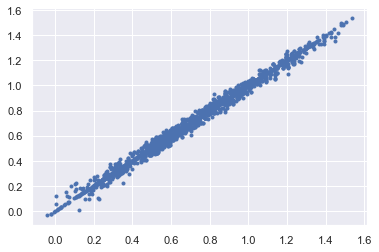

In [186]:
plt.plot(x, y, '.')

### Difference in predicted skill difference.

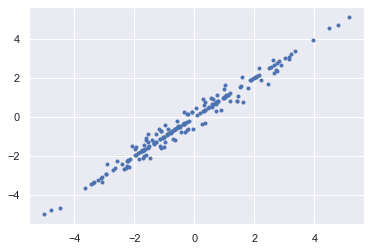

In [191]:
plt.plot(
    (match_pred.df.radi_skill - match_pred.df.dire_skill)[-193:],
     (match_pred_numba.df.radi_skill - match_pred_numba.df.dire_skill)[-193:],
     '.')

### Difference in predicted win probability.

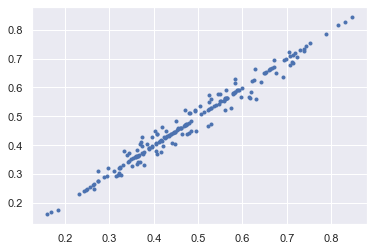

In [190]:
plt.plot(match_pred.df.pred_win_prob_unknown_side[-193:],
         match_pred_numba.df.pred_win_prob_unknown_side[-193:],
         '.')

### AUC

In [173]:
idx = slice(-193)
traces = [
    src.stats._prediction_to_plotly_roc_data(
        match_pred.df.iloc[idx].radiantVictory,
        match_pred.df.iloc[idx].pred_win_prob_unknown_side,
        "Python fitting: {}".format(match_pred._roc_auc(False, iloc=idx))),
    src.stats._prediction_to_plotly_roc_data(
        match_pred_numba.df.iloc[idx].radiantVictory,
        match_pred_numba.df.iloc[idx].pred_win_prob_unknown_side,
        "Numba fitting: {}".format(
            match_pred_numba._roc_auc(False, iloc=idx)))
]
src.stats.roc_curve_plotly_plot(traces)

## In terms of Fairlay odds.

### Load Fairlay odds.

In [13]:
fl = pd.read_pickle("data/external/dota2_markets.20190831.pkl")
sel = ((fl.Comp == 'Dota 2 - The International')
       & (fl.dota_market_type == 'map'))
fl_f = (fl.loc[sel].sort_values('LastCh')
        .groupby(['ID', 'wager_type', 'RunnerName'])
        .apply(lambda d: d.iloc[0]))

### Map Fairlay odds to match predictions.

In [176]:
def merge_fl_pred(match_pred_obj, fl_df):
    # Fix team name of Infamous.
    fl_df_teams = fl_df.Title.str.extract(r'^(.+) vs. (.+)$')
    fl_df['RunnerName'] = fl_df['RunnerName'].str.replace('Infamous',
                                                        'Infamous Gaming')
    for i in (0, 1):
        fl_df_teams[i][fl_df_teams[i] == 'Infamous'] = 'Infamous Gaming'
    
    # Match teams.
    pred_win_prob = match_pred_obj.query_maps(
        fl_df_teams[0],
        fl_df_teams[1],
        (fl_df.Descr.str[0].astype(int) - 1),
        fl_df.ClosD)
    pred_win_prob.index = fl_df.index
    fl_df_pred = fl_df.merge(pred_win_prob, left_index=True, right_index=True)
    fl_df_pred = fl_df_pred.loc[fl_df_pred.map_id.notna()]
    fl_df_pred = fl_df_pred.merge(match_pred_obj.df, left_on='map_id',
                                  right_index=True)
    fl_df_pred['team_1_won'] = np.where(fl_df_pred.flipped,
                                        ~fl_df_pred.radiantVictory,
                                        fl_df_pred.radiantVictory)
    fl_df_pred['team_1_win_prob'] = np.where(
        fl_df_pred.flipped,
        1 - fl_df_pred.pred_win_prob_unknown_side,
        fl_df_pred.pred_win_prob_unknown_side)
    fl_df_pred['startDate'] = (fl_df_pred['startDate'].dt.tz_localize('UTC')
                               .dt.tz_convert('US/Eastern'))
    fl_df_pred['time_diff'] = \
        (fl_df_pred.startDate - fl_df_pred.ClosD) / pd.Timedelta(minutes=1)
    fl_df_pred['ev'] = np.where(
        fl_df_pred.wager_type == 'on',
        fl_df_pred.team_1_win_prob * fl_df_pred.odds_c - 1,
        (1 - fl_df_pred.team_1_win_prob) * fl_df_pred.odds_c - 1)
    fl_df_pred['outcome'] = np.where(
        np.logical_or(np.logical_and(fl_df_pred.wager_type == 'on',
                                     fl_df_pred.team_1_won),
                      np.logical_and(fl_df_pred.wager_type == 'against',
                                     np.logical_not(fl_df_pred.team_1_won))),
        fl_df_pred.odds_c - 1,
        -1)
    
    # Compute selectors.
    sel = pd.DataFrame({
        'correct_match': fl_df_pred['time_diff'] >= -2000,
        'before_match': fl_df_pred['LastSoftCh'] <= fl_df_pred['startDate'],
        'pos_ev': fl_df_pred['ev'] > 0,
        'pred_underdog':
            (fl_df_pred.team_1_win_prob > 0.5)
            ^ (fl_df_pred.wager_type == 'on'),
        'pred_favourite':
            (fl_df_pred.team_1_win_prob < 0.5)
            ^ (fl_df_pred.wager_type == 'on'),
        'odds_underdog':
            (fl_df_pred.groupby(fl_df_pred.index.droplevel(1))['odds']
             .transform(lambda x: x > min(x))),
        'odds_favourite':
            (fl_df_pred.groupby(fl_df_pred.index.droplevel(1))['odds']
             .transform(lambda x: x < max(x))),
        'map1': fl_df_pred.Descr == '1st Map',
        'map2': fl_df_pred.Descr == '2nd Map',
        'map3': fl_df_pred.Descr == '3rd Map',
        'group_stage':
            (fl_df_pred.startDate < '2019-08-18 12:00:00-04:00')
            .fillna(False),
        'playoffs':
            (fl_df_pred.startDate >= '2019-08-18 12:00:00-04:00')
            .fillna(False),
    })
    return fl_df_pred, sel

### Helper functions for printing betting outcomes.

In [141]:
def emp_poibin_ci(win_probs, win_amt, loss_amt, alpha):
    outcome = np.where(
        np.isnan(win_probs),
        np.nan,
        scipy.stats.bernoulli.rvs(np.nan_to_num(win_probs, nan=0)))
    total_reward = np.sum(np.where(outcome, win_amt, loss_amt), 1)
    return np.quantile(total_reward, (alpha, 1 - alpha))

In [149]:
def outcome_printer(fl_f, bool_vec, title=None):
    fl_f_f = fl_f.loc[bool_vec]
    grp_cols = ['map_id', 'wager_type', 'RunnerName']
    first_ch_of_map = \
        (fl_f.drop(['wager_type', 'RunnerName'], 1)
             .groupby(grp_cols)['LastSoftCh']
             .apply(lambda x: x == min(x)))

    if title is not None:
        print(title + "\n" + "-" * len(title))
    print("Maps included: {}/{}".format(sum(bool_vec), fl_f.shape[0]))
    
    # Compute empirical confidence interval for total reward.
    N = 100000
    alpha = 0.025
    win_probs = np.repeat(
        np.where(fl_f_f.wager_type == 'on', fl_f_f.pred_win_prob,
                 1 - fl_f_f.pred_win_prob).reshape(1, -1),
        N,
        axis=0)
    empirical_ci = emp_poibin_ci(
        win_probs,
        np.repeat(
            (fl_f_f.odds_c - 1).values.reshape(1, -1), N,
            axis=0),
        -np.ones((N, fl_f_f.shape[0])),
        alpha)
    
    # Compute approximated confidence interval for total reward.
    total_ev = fl_f_f.ev.sum()
    print("Total EV: {:.2f} ({:.2f}, {:.2f})".format(
        total_ev,
        empirical_ci[0],
        empirical_ci[1]))
    print("Total outcome: {}".format(fl_f_f.outcome.sum()))
    print("")

### Results for pure Python.

In [177]:
fl_pred, sel = merge_fl_pred(match_pred, fl_f)

In [178]:
outcome_printer(
    fl_pred,
    sel.correct_match & sel.pos_ev & sel.before_match & sel.playoffs,
    "Playoffs positive EV bets")

outcome_printer(
    fl_pred,
    sel.correct_match & sel.pos_ev & sel.before_match & sel.group_stage,
    "Group stage positive EV bets")

Playoffs positive EV bets
-------------------------
Maps included: 30/794
Total EV: 2.68 (-7.61, 16.75)
Total outcome: 5.063000000000001

Group stage positive EV bets
----------------------------
Maps included: 132/794
Total EV: 19.11 (-10.68, 44.30)
Total outcome: 11.34



### Results for Python Numba.

In [179]:
fl_pred_numba, sel_numba = merge_fl_pred(match_pred_numba, fl_f)

In [180]:
outcome_printer(
    fl_pred_numba,
    sel_numba.correct_match & sel_numba.pos_ev & sel_numba.before_match
        & sel_numba.playoffs,
    "Playoffs positive EV bets")

outcome_printer(
    fl_pred_numba,
    sel_numba.correct_match & sel_numba.pos_ev & sel_numba.before_match
        & sel_numba.group_stage,
    "Group stage positive EV bets")

Playoffs positive EV bets
-------------------------
Maps included: 30/794
Total EV: 2.48 (-7.69, 16.87)
Total outcome: 5.053000000000001

Group stage positive EV bets
----------------------------
Maps included: 129/794
Total EV: 19.68 (-11.06, 43.45)
Total outcome: 13.895999999999999



### Sanity check.

In [175]:
(fl_pred.ev - fl_pred_numba.ev).max()

0.0